<a href="https://colab.research.google.com/github/GonzaloMA-17/k_brazos_FJLGM/blob/main/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Asignatura**: Extensiones de Machine Learning, 2024/2025

**Alumnos**:<br>
- Gonzalo Marcos Andrés (gonzalo.marcosa@um.es)
- Francisco José López Fernández (franciscojose.lopezf@um.es)

**Máster de Inteligencia Artificial**

| **Facultad de Informática** | **Universidad de Murcia** |
|-----------------------------|---------------------------|
| ![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242) | ![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png) |


# Estudio comparativo de algoritmos en un problema de bandido de k-brazos


**Introducción al Algoritmo UCB1 y UCB2 para el Problema del Bandido Multibrazos**

Los algoritmos UCB1 y UCB2 están diseñados para equilibrar la exploración y la explotación en el contexto del problema del bandido multibrazos. A lo largo de múltiples ejecuciones y pasos, estos algoritmos intentan identificar el brazo óptimo, pero también exploran otros brazos con el objetivo de reducir la incertidumbre sobre sus recompensas potenciales.
- **UCB1**

Calcula una estimación de la recompensa para cada brazo y ajusta esta estimación según la incertidumbre sobre los brazos no explorados, favoreciendo aquellos con menos pruebas. La idea es que, a medida que más información sobre los brazos se va acumulando, se reduce la incertidumbre y se puede tomar decisiones más fundamentadas.  

- **UCB2**

Mientras que UCB1 utiliza una penalización basada en el logaritmo del tiempo total de iteración, UCB2 ajusta esta penalización utilizando el logaritmo del logaritmo del tiempo. Esto hace que UCB2 sea más conservador en la exploración, favoreciendo la explotación más rápidamente que UCB1. 

**Comparativa entre UCB1 y UCB2**

| Característica               | **UCB1**                               | **UCB2**                                  |
|------------------------------|----------------------------------------|-------------------------------------------|
| **Fórmula de exploración**    | \( \sqrt{\frac{2 \ln t}{n_a}} \)       | \( \sqrt{\frac{2 \ln (\ln t)}{n_a}} \)    |
| **Exploración vs Explotación**| Equilibrio estándar                    | Penalización más suave de exploración     |
| **Velocidad de Convergencia** | Más lenta en algunos casos             | Más rápida debido a la menor penalización |
| **Escenarios ideales**        | Ideal cuando la exploración debe ser moderada | Mejor para tareas con baja necesidad de exploración |

## Preparación del entorno

**Clonación del repositorio:**

Para poder acceder a todas las clases y métodos necesarios.

In [1]:
# !git clone https://github.com/GonzaloMA-17/k_brazos_FJLGM.git

In [2]:
# %cd k_brazos_FJLGM

### Librerías

In [3]:
import numpy as np
from typing import List

from src_algorithms import Algorithm,  UCB2, UCB1
from src_arms import *
from src_plotting import *

Semilla:

In [4]:
seed = 1234

**Definición del experimento:**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número determinado de pasos de tiempo y ejecuciones. Se comparan los resultados de los algoritmos en términos de recompensa promedio obtenida a lo largo de las ejecuciones.

Por ejemplo, dado un bandido de k brazos, se ejecutan dos algoritmos UCB1 y dos UCB2 con diferentes configuraciones de penalización en la exploración. El experimento se realiza durante un número de pasos, por ejemplo, 1000 pasos. Luego, se repite el experimento varias veces, como 500 ejecuciones, para obtener resultados consistentes. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso, se calcula el promedio de las recompensas obtenidas durante esas 500 ejecuciones.

In [5]:
def run_experiment(bandit, algorithms, steps, runs):
    """
    Ejecuta experimentos comparativos entre diferentes algoritmos de bandido multibrazo.

    Parameters
    ----------
    bandit : object
        Objeto que representa el bandido con k brazos y métodos:
          - pull_arm(arm_index)
          - get_expected_value(arm_index)
        Debe tener atributos:
          - k : int (número de brazos)
          - optimal_arm : int (índice del brazo óptimo)
    algorithms : list
        Lista de objetos, cada uno con métodos:
          - reset()
          - select_arm()
          - update(arm_index, reward)
    steps : int
        Número de pasos (jugadas) por ejecución.
    runs : int
        Número de ejecuciones independientes.

    Returns
    -------
    rewards : np.ndarray
        Matriz de tamaño (len(algorithms), steps) con la recompensa promedio
        en cada paso, promediada sobre todas las ejecuciones.
    optimal_selections : np.ndarray
        Matriz de tamaño (len(algorithms), steps) con el porcentaje de veces
        que se seleccionó el brazo óptimo en cada paso.
    """

    # Número de brazos y brazo óptimo
    k = bandit.k
    optimal_arm = bandit.optimal_arm

    # Matrices para almacenar resultados
    rewards = np.zeros((len(algorithms), steps))
    optimal_selections = np.zeros((len(algorithms), steps))

    for run in range(runs):
        # Crear una nueva instancia del bandido (si deseas "reiniciar" su estado en cada ejecución).
        # Asegúrate de que tu clase Bandit acepte este constructor si lo necesitas.
        current_bandit = type(bandit)(arms=bandit.arms)

        # Reiniciar cada algoritmo antes de cada ejecución
        for algo in algorithms:
            algo.reset()

        # Ejecutar el bucle de pasos
        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                # Seleccionar un brazo
                chosen_arm = algo.select_arm()
                # Obtener recompensa del bandido
                reward = current_bandit.pull_arm(chosen_arm)
                # Actualizar el algoritmo con la recompensa recibida
                algo.update(chosen_arm, reward)

                # Acumular la recompensa
                rewards[idx, step] += reward

                # Verificar si el brazo elegido es el óptimo
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    # Promediar las recompensas y selecciones óptimas a lo largo de las ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100.0

    return rewards, optimal_selections

**Ejecución del experimento**:

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Bernoulli de probabilidad **p**. 

Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan dos algoritmos de la familia de **UCB**: 

- *UCB1*
- *UCB2*.

In [6]:
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 2 algoritmos UCB1 y 2 algoritmos UCB2 con diferentes valores.
algorithms = [UCB2(k=k, alpha_param=0.2),UCB2(k=k, alpha_param=0.9),UCB1(k=k, c=0.1),UCB1(k=k, c=1.0)] #, GradientPreference(k=k, alpha=0.1), GradientPreference(k=k, alpha=0.4)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.25), ArmBernoulli(p=0.6), ArmBernoulli(p=0.45), ArmBernoulli(p=0.72), ArmBernoulli(p=0.73), ArmBernoulli(p=0.32), ArmBernoulli(p=0.74), ArmBernoulli(p=0.87), ArmBernoulli(p=0.8), ArmBernoulli(p=0.39)
Optimal arm: 8 with expected reward=0.87


#### **Visualización de resultados**:

- Recompensa Promedio vs Pasos de Tiempo
- Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo

### Recompensa Promedio vs Pasos de Tiempo

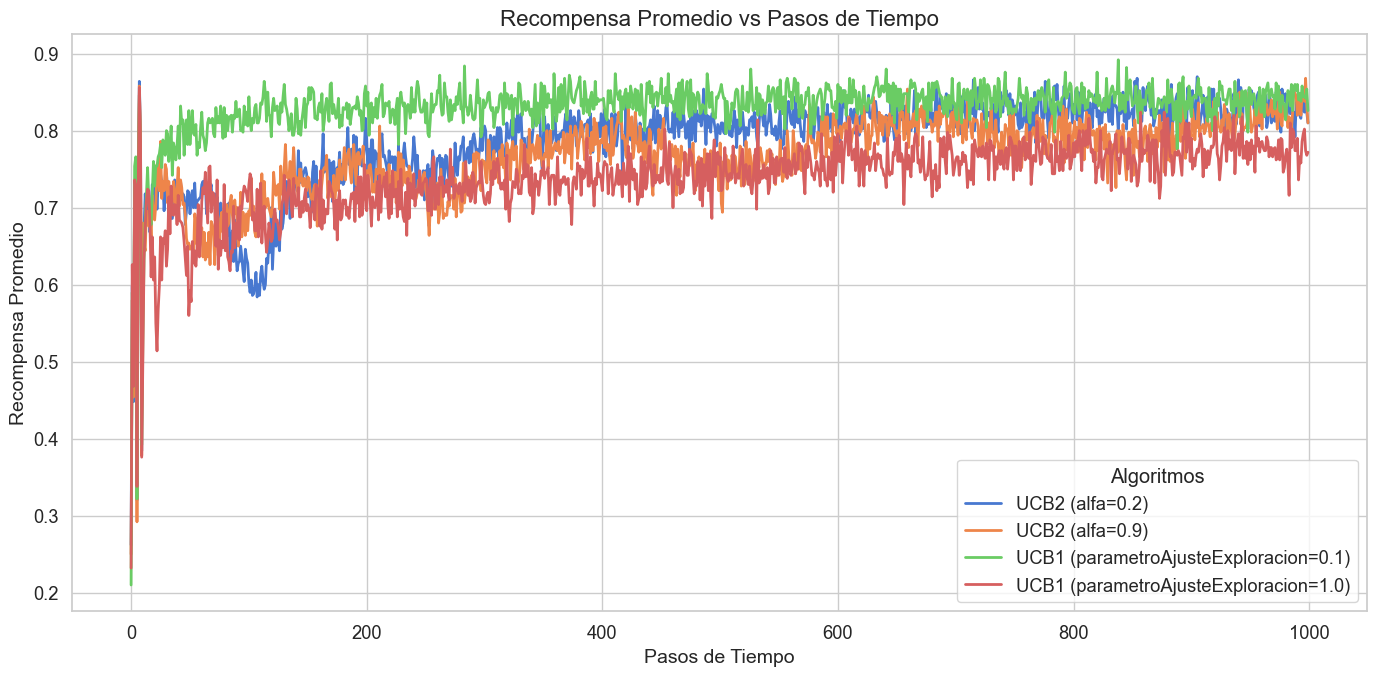

In [7]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
# plot_optimal_selections(steps, optimal_selections, algorithms)

**Recompensa Promedio vs Pasos de Tiempo**

En esta gráfica se analizan cuatro variantes del algoritmo **UCB** (Upper Confidence Bound) aplicadas a un problema de Bandido Multibrazos.

**Ejes**  

- **Eje X**: Representa los pasos o iteraciones (de 0 a 1000).  
- **Eje Y**: Muestra la recompensa promedio acumulada por cada variante de UCB.  

**Línea Azul: UCB2 (α = 0.2)**  
- Ajusta la exploración con épocas relativamente cortas (α = 0.2).  
- Observamos que, tras los primeros pasos, alcanza recompensas promedio en torno a **0.81** y mantiene un nivel estable. Las oscilaciones iniciales se deben a la fase de exploración, pero se estabilizan rápidamente debido a la menor penalización en la exploración.

**Línea Naranja: UCB2 (α = 0.9)**  
- Asigna épocas más largas (α = 0.9), aumentando la exploración.  
- Llega a valores similares a la variante azul (cerca de 0.81), aunque con más oscilaciones al principio. Estas oscilaciones son más pronunciadas debido a la mayor penalización en la exploración, lo que retrasa la explotación del mejor brazo.

**Línea Verde: UCB1 (c = 0.1)**  
- Reduce la bonificación de exploración (c=0.1), lo que permite concentrarse antes en los brazos más prometedores.  
- En esta gráfica, **logra la mejor recompensa promedio**, superando **0.85**. Las oscilaciones iniciales son menores debido a la rápida explotación del mejor brazo, lo que resulta en una recompensa promedio más alta.

**Línea Roja: UCB1 (c = 1.0)**  
- Incrementa la bonificación de exploración (c=1.0), lo que puede retrasar la explotación del mejor brazo.  
- Se sitúa alrededor de **0.77** al final, un poco por debajo del resto. Las oscilaciones son más pronunciadas debido a la mayor exploración, lo que retrasa la convergencia hacia el mejor brazo.

**Observaciones Destacadas**  
- **Mejor Desempeño**:  
El **UCB1 (c = 0.1)** (verde) exhibe la recompensa promedio **más alta** al final de los 1000 pasos, lo que indica que, en este entorno, una exploración moderada equilibra bien el aprendizaje y la explotación. 

- **UCB2 vs. UCB1**:  
Ambas variantes de UCB2 alcanzan recompensas similares (en torno a 0.81), pero con diferentes niveles de oscilación debido a la variación en la penalización de exploración. UCB1 con c=0.1 supera a UCB2 en términos de recompensa promedio, mientras que UCB1 con c=1.0 queda rezagado debido a la exploración excesiva.

- **Exceso de Exploración**: El **UCB1 (c = 1.0)** (rojo) queda algo rezagado; su exploración más intensa no consigue una recompensa tan alta a largo plazo.  

**Conclusión General**: 

Todos los algoritmos convergen a valores de recompensa promedio relativamente altos, entre **0.77 y 0.85**. No obstante, ajustar el parámetro de exploración es crucial para obtener el **máximo** desempeño. Una exploración moderada (UCB1 con c=0.1) permite una rápida explotación del mejor brazo, resultando en una mayor recompensa promedio. Por otro lado, una exploración excesiva (UCB1 con c=1.0) retrasa la convergencia y reduce la recompensa promedio.


### Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo

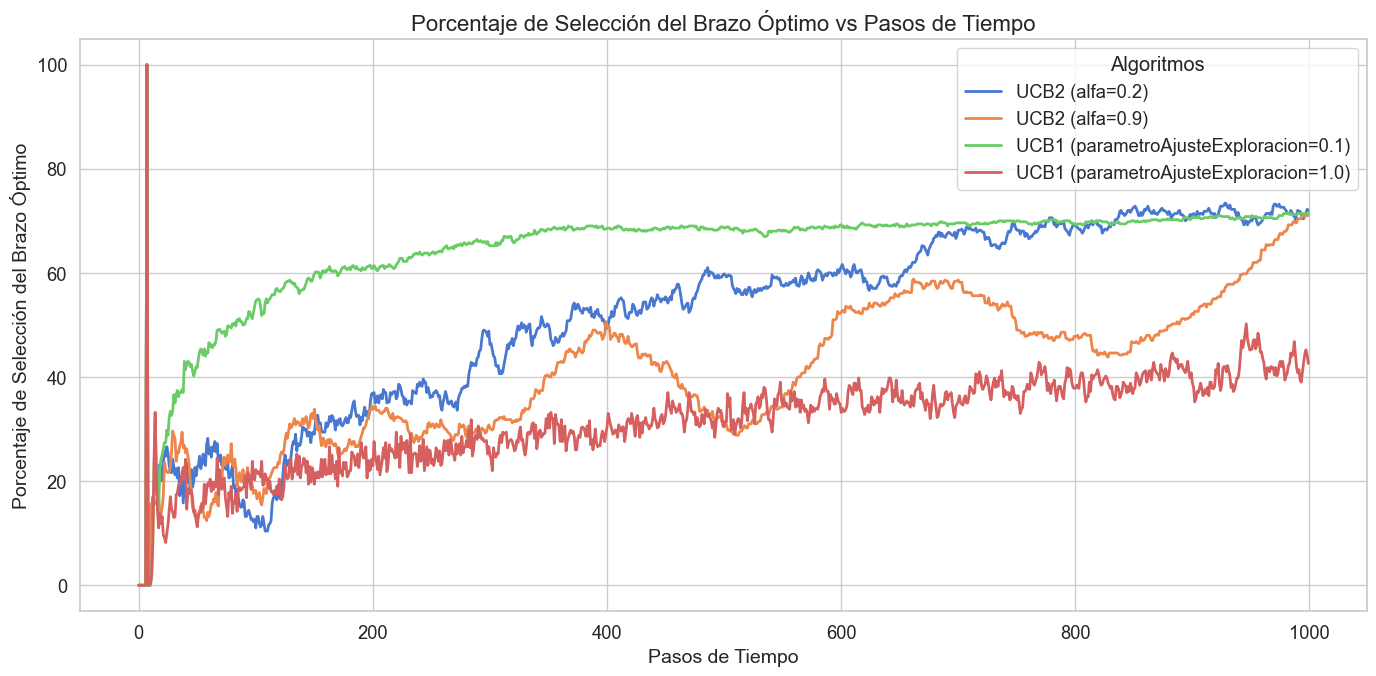

In [8]:
plot_optimal_selections(steps, optimal_selections, algorithms)

**Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**

En esta gráfica se muestra el porcentaje con el que cada algoritmo selecciona el **brazo óptimo** a lo largo de 1000 pasos en un problema de Bandido Multibrazos.

**Ejes**  
- **Eje X**: Representa los pasos o iteraciones (de 0 a 1000).  
- **Eje Y**: Muestra el porcentaje de veces que se selecciona el brazo óptimo (de 0% a 100%).

**Línea Azul: UCB2 (α = 0.2)**  
- Utiliza épocas de exploración relativamente cortas.  
- Se observa cómo, tras un periodo inicial, incrementa su porcentaje de selección del brazo óptimo y se mantiene en una zona alta, rondando el 72%. Las oscilaciones iniciales son moderadas, estabilizándose rápidamente debido a la menor penalización en la exploración.

**Línea Naranja: UCB2 (α = 0.9)**  
- Emplea épocas más largas (mayor exploración).  
- Al principio presenta más variaciones, pero finalmente se acerca a un porcentaje cercano al de la línea azul, aunque con oscilaciones más notables, manteniéndose alrededor del 71%.

**Línea Verde: UCB1 (c = 0.1)**  
- Disminuye el factor de exploración (c=0.1), concentrándose antes en el brazo ganador.  
- En esta gráfica, alcanza rápidamente un porcentaje alto (alrededor de 71.4%), consolidándose como una opción consistente en seleccionar el brazo óptimo. Las oscilaciones iniciales son menores debido a la rápida explotación del mejor brazo.

**Línea Roja: UCB1 (c = 1.0)**  
- Aumenta la bonificación de exploración, lo que retrasa la convergencia en la selección del mejor brazo.  
- Permanece algo más abajo, alrededor del 42.6% al final, con oscilaciones más pronunciadas debido a la mayor exploración, lo que retrasa la explotación del mejor brazo.

**Observaciones Destacadas**  
- **Mejor Desempeño**:  
El **UCB1 (c = 0.1)** (verde) exhibe el porcentaje de selección del brazo óptimo **más alto** al final de los 1000 pasos, lo que indica que, en este entorno, una exploración moderada equilibra bien el aprendizaje y la explotación. 

- **UCB2 vs. UCB1**:  
Ambas variantes de UCB2 alcanzan porcentajes similares (en torno al 71-72%), pero con diferentes niveles de oscilación debido a la variación en la penalización de exploración. UCB1 con c=0.1 supera a UCB2 en términos de porcentaje de selección del brazo óptimo, mientras que UCB1 con c=1.0 queda rezagado debido a la exploración excesiva.

- **Exceso de Exploración**: El **UCB1 (c = 1.0)** (rojo) queda significativamente rezagado; su exploración más intensa no consigue un porcentaje tan alto a largo plazo.  

**Conclusión General**: 

Todos los algoritmos incrementan gradualmente la **frecuencia de selección del brazo óptimo** a medida que avanzan las jugadas. Sin embargo, la manera en que cada algoritmo equilibra la **exploración** (probar otros brazos) y la **explotación** (seguir con el brazo más prometedor) depende directamente de sus parámetros:

- **UCB1 (c=0.1)**  
    - Demuestra la **mayor rapidez** en converger hacia el brazo óptimo y mantiene el **porcentaje de selección** más alto en la fase final.  
    - Un valor moderado de \(c\) parece ajustarse bien a este entorno, ya que no se explora en exceso y se aprovecha de manera eficiente el mejor brazo identificado.

- **UCB1 (c=1.0)**  
    - La **exploración elevada** retrasa la explotación del mejor brazo.  
    - Aunque también crece en el tiempo, se observa un **porcentaje de selección menor** que en la versión con \(c=0.1\).

- **UCB2 (α=0.2 y α=0.9)**  
    - Ambas variantes muestran tendencias similares: a la larga alcanzan porcentajes altos de selección del brazo óptimo.  
    - La diferencia principal está en la **velocidad de convergencia** y en la **estabilidad** de la curva, influidas por la duración de las épocas de exploración que marca \(\alpha\).

Los resultados confirman la importancia de **afinar los parámetros de exploración** en los algoritmos de la familia UCB. Un ajuste adecuado permite **converger más rápidamente** al brazo ganador y **mantener** un alto porcentaje de selección óptima, mientras que una exploración excesiva puede **dilatar** el tiempo necesario para identificar y explotar eficazmente la mejor opción.
